### Using Median Absolute Deviation to Measure Impact of Demographic Features - redone to remove records  with questionable age and years since registered

In [1]:
# First set everthing up
import pyodbc
import graphlab as gl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import local # server information and credentials
import statsmodels.robust.scale as sm # for median absolute deviation (MAD)
import seaborn as sns
from pullODBC import pullODBC
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 10
plt.tight_layout;
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
pd.options.display.float_format = '{:.3f}'.format # display as floating point to 3 decimal places

C:\Anaconda\envs\gl-env\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # for a wide screen

First retrieve the coefficient dataframe and the full demographics dataframe from their pickle files that I used for prediction.  Drivers License was not a significant influencer so it is not in the final model.  Also note that the final model for this analysis did not remove the outliers since we are now using Median Absolute Deviation which is less sensitive to these.

In [3]:
coeff_df = pd.read_pickle('coefficients_df')
demographics = pd.read_pickle('demographics_df')

Let's check age and years since registrations to ensure that we've removed the questionable records.

In [4]:
min_age = demographics['birth_age'].min().astype(int)
max_age = demographics['birth_age'].max().astype(int)
min_years = demographics['years_since_registration'].min().astype(int)
max_years = demographics['years_since_registration'].max().astype(int)
print "The minumum age in the population is " + str(min_age)
print "The maximum age in the population is " + str(max_age)
print "The minumum years in the population is " + str(min_years)
print "The maximum years in the population is " + str(max_years)

The minumum age in the population is 17
The maximum age in the population is 99
The minumum years in the population is 0
The maximum years in the population is 60


(array([  824027.,   917534.,   849447.,   925463.,   971020.,  1001710.,
          673129.,   357123.,   166263.,    45475.]),
 array([ 17. ,  25.2,  33.4,  41.6,  49.8,  58. ,  66.2,  74.4,  82.6,
         90.8,  99. ]),
 <a list of 10 Patch objects>)

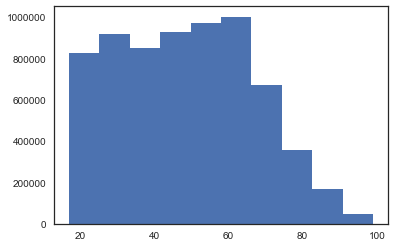

In [5]:
plt.hist(demographics['birth_age'])

This confirms all ages are 'good' so we'll use ages 17 thru 99

(array([ 2500853.,  1332973.,   947561.,   645404.,   474929.,   278278.,
          230858.,   181858.,   116209.,    22268.]),
 array([  3.83307296e-02,   6.13428569e+00,   1.22302406e+01,
          1.83261956e+01,   2.44221506e+01,   3.05181055e+01,
          3.66140605e+01,   4.27100154e+01,   4.88059704e+01,
          5.49019254e+01,   6.09978803e+01]),
 <a list of 10 Patch objects>)

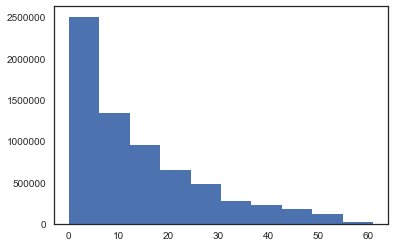

In [6]:
plt.hist(demographics['years_since_registration'])

This confirms all years are 'good' so we'll use years 0 thru 60

Next, create a new dataframe for coefficient statistics, calculate these statistics for categorical variables, and add these to the dataframe

In [7]:
coeff_df['value'].astype('float64') # Ensure that values are float64
coeff_statistics_df = pd.DataFrame(data=None, index=None, columns=['COEF','MIN', 'MAX', 'RANGE', 'MAD'], 
                                 dtype='float64', copy=False) # Create an empty dataframe for statistics
names = coeff_df['name'].unique() # names has all the feature values 
# Iterate through all the features with more than 1 coeffient value (the categorical varaiabes) 
# and add statistics about the coefficient values to coeff_statistics_df
for coeff in names:
    df = coeff_df[coeff_df['name']== coeff]
    if len(df) > 1:
        new_row = pd.DataFrame([[coeff, df['value'].min(), df['value'].max(), df['value'].ptp(), 
                                 sm.mad(df['value'])]], columns=['COEF','MIN', 'MAX', 'RANGE', 'MAD']) 
                               
        coeff_statistics_df = coeff_statistics_df.append(new_row, ignore_index=False)
        
coeff_statistics_df.sort_values('MAD', axis=0, ascending=False, inplace=True, 
                              kind='quicksort', na_position='last') # sort the dataframe on Median Absolute Deviation

In [8]:
print coeff_statistics_df # print the sorted statistics for the categorical variables

               COEF     MIN    MAX  RANGE   MAD
0          zip_code -18.635 19.303 37.938 0.567
0    race_ethnicity  -1.948  0.354  2.302 0.312
0       race_gender  -1.956  0.111  2.067 0.288
0  gender_ethnicity  -0.933 -0.281  0.651 0.274
0       birth_state  -0.141 17.721 17.862 0.171


Now let's work on continuous features

First, extract all the relevant coefficients

In [9]:
#coeff_df = coeff_df.to_dataframe()
birth_age = coeff_df[coeff_df['name']=='birth_age']['value'].iloc[0]
age_squared=coeff_df[coeff_df['name']=='age_squared']['value'].iloc[0]
age_cubed=coeff_df[coeff_df['name']=='age_cubed']['value'].iloc[0]
years_since_registration = coeff_df[coeff_df['name']=='years_since_registration']['value'].iloc[0]
years_squared = coeff_df[coeff_df['name']=='years_squared']['value'].iloc[0]
years_cubed = coeff_df[coeff_df['name']=='years_cubed']['value'].iloc[0]

Create a new row containing statistics on years since registration

In [10]:
years_formula = 'years_since_registration*x + years_squared*x**2 + years_cubed*x**3'
x = np.array(range(0,61)) # 0 thru 60
y = eval(years_formula)
y = pd.Series(y)
new_row_years = pd.DataFrame([['years_since_reg', y.min(), y.max(), y.ptp(), sm.mad(y)]],
                              columns=['COEF','MIN', 'MAX', 'RANGE', 'MAD'])
print new_row_years

              COEF    MIN   MAX  RANGE   MAD
0  years_since_reg -1.263 0.000  1.263 0.283


Create a new row containing statistics on age

In [11]:
years_formula = 'birth_age*x + age_squared*x**2 + age_cubed*x**3'
x = np.array(range(17,100)) #17 thru 99
y = eval(years_formula)
y = pd.Series(y)
new_row_age = pd.DataFrame([['birth_age', y.min(), y.max(), y.ptp(), sm.mad(y)]],
                              columns=['COEF','MIN', 'MAX', 'RANGE', 'MAD'])
print new_row_age

        COEF    MIN   MAX  RANGE   MAD
0  birth_age -0.606 0.021  0.627 0.163


Add the rows with statistics on age and years since registration to the dataframe, sort by MAD, and print

In [12]:
coeff_statistics_df = coeff_statistics_df.append(new_row_years, ignore_index=False)
coeff_statistics_df = coeff_statistics_df.append(new_row_age, ignore_index=False)
coeff_statistics_df.sort_values('MAD', axis=0, ascending=False, inplace=True, 
                              kind='quicksort', na_position='last')

Final Analysis of Demographic Features' Influence on Party Sentiment Sorted by Median Absolute Deviation

In [13]:
print coeff_statistics_df

               COEF     MIN    MAX  RANGE   MAD
0          zip_code -18.635 19.303 37.938 0.567
0    race_ethnicity  -1.948  0.354  2.302 0.312
0       race_gender  -1.956  0.111  2.067 0.288
0   years_since_reg  -1.263  0.000  1.263 0.283
0  gender_ethnicity  -0.933 -0.281  0.651 0.274
0       birth_state  -0.141 17.721 17.862 0.171
0         birth_age  -0.606  0.021  0.627 0.163


### Exploring the Distribution of the Probability of Leaning Republican

Plot histograms with rug both with and without kernel density.  

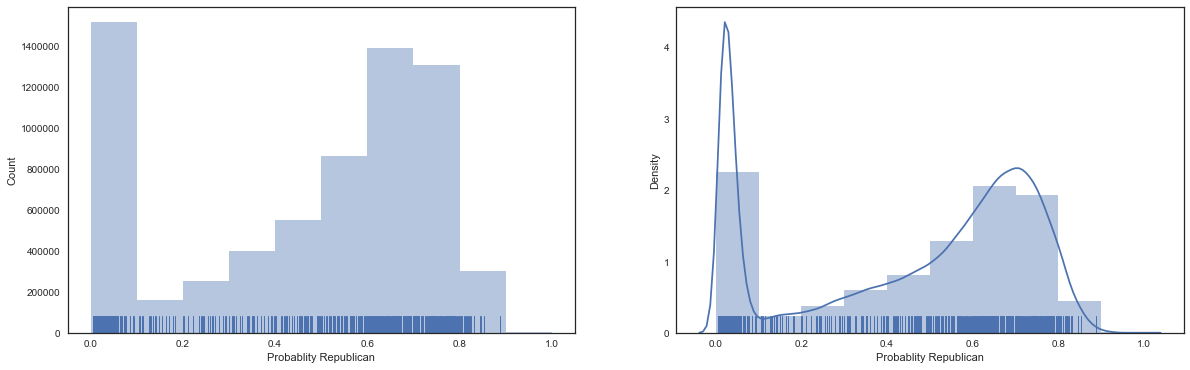

In [14]:
fig, axs = plt.subplots(figsize=(20,6), ncols=2, nrows=1)
# Without Kernel Density
hist = sns.distplot(demographics['percent'],bins=np.arange(0, 1.1, 0.1),norm_hist=False, vertical=False, kde=False, ax=axs[0])
sample = demographics['percent'].sample(frac=0.00009)
rug = sns.rugplot(sample, ax=axs[0])
# With Kernel Density
hist = sns.distplot(demographics['percent'],bins=np.arange(0, 1.1, 0.1),norm_hist=False, vertical=False, kde=True, ax=axs[1])
rug = sns.rugplot(sample, ax=axs[1])
# Labels
axs[0].set_xlabel('Probablity Republican')
axs[0].set_ylabel('Count')
axs[1].set_xlabel('Probablity Republican')
axs[1].set_ylabel('Density')

### Characterizing the demographics of voters with probability republican <= 0.1

In [15]:
low_prob_df = demographics[demographics['percent']<= 0.1]
low_prob_df.columns

Index([u'birth_age', u'party_cd', u'status_cd', u'zip_code', u'birth_state',
       u'drivers_lic', u'county_desc', u'precinct_abbrv', u'race_gender',
       u'race_ethnicity', u'gender_ethnicity', u'age_squared', u'age_cubed',
       u'years_since_registration', u'years_squared', u'years_cubed',
       u'percent', u'predict_positive', u'actual_or_predicted'],
      dtype='object')

In [16]:
analysis = low_prob_df.groupby(['race_gender'])['race_gender'].count()/low_prob_df.groupby(['race_gender'])['race_gender'].count().sum()
pd.options.display.float_format = '{:.1%}'.format #display as percentages

In [17]:
print analysis.sort_values(ascending = False)

race_gender
BF   55.5%
BM   41.5%
BU    1.1%
MF    0.4%
IF    0.3%
OF    0.3%
UF    0.2%
WF    0.2%
UU    0.1%
OM    0.1%
UM    0.1%
AF    0.1%
MM    0.1%
IM    0.1%
AM    0.0%
WM    0.0%
AU    0.0%
MU    0.0%
OU    0.0%
WU    0.0%
IU    0.0%
Name: race_gender, dtype: float64


Conclusion:  98.5% of voters with probability of having Republican sentiment <= 0.1 are African American